In [1]:
# Uncomment to install imblearn (if needed) and restart kernel
#pip install imblearn --user

In [2]:
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.datasets import make_classification as MC
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs as MB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Data with Weighted Classes

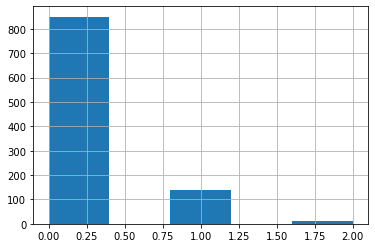

,0,1,2,3,4,label
0,-10.800342,3.172799,5.239638,7.307207,5.994013,0
1,-14.990925,3.017590,3.977746,5.360931,4.784813,0
2,-11.717584,1.484062,6.603974,7.225007,3.876819,0
3,-11.451783,2.013037,5.301218,7.659808,8.734456,2
4,-10.977639,4.676936,6.553846,7.233869,4.575602,0


In [3]:
data = pd.read_csv('http://apmonitor.com/pds/uploads/Main/imbalanced_train.csv')
datat = pd.read_csv('http://apmonitor.com/pds/uploads/Main/imbalanced_test.csv')
data.columns = [0,1,2,3,4,'label']
datat.columns = [0,1,2,3,4,'label']
data['label'].hist(bins=5)
plt.show()
data.head()

### Visualize Data

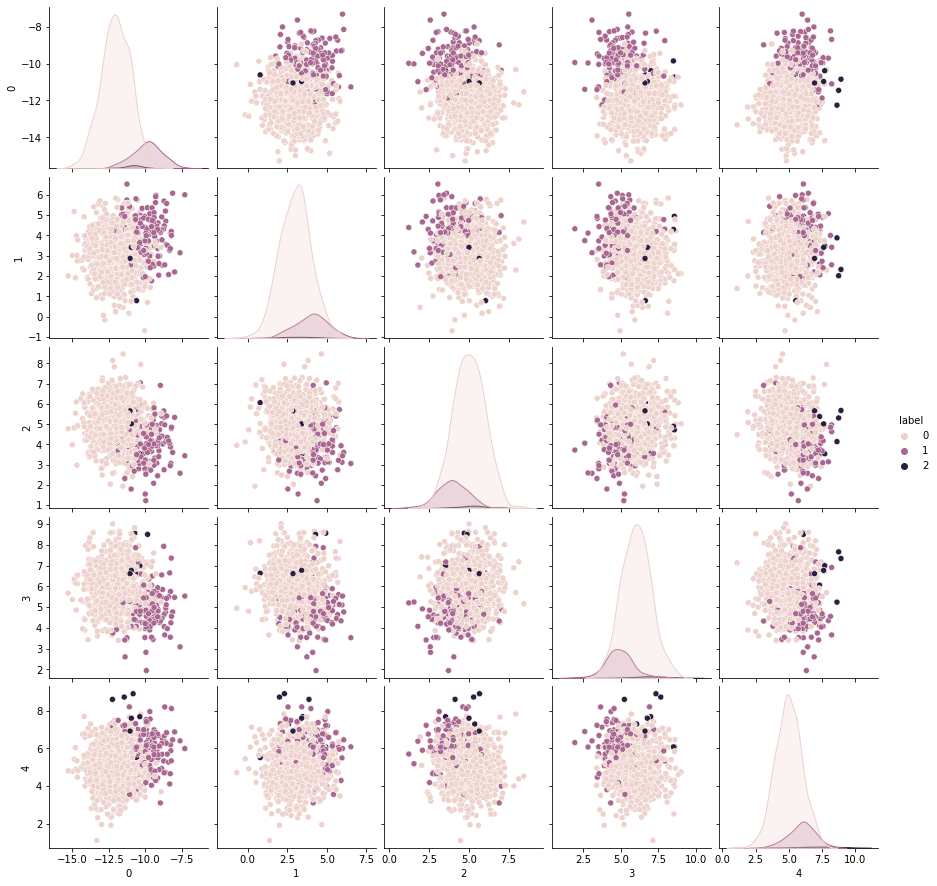

In [4]:
sns.pairplot(data,hue='label')
plt.show()

### Find and drop redundant columns

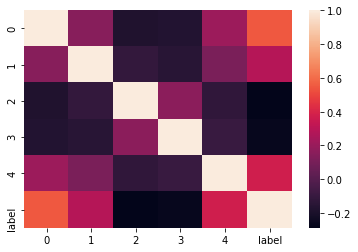

In [5]:
sns.heatmap(data.corr())
plt.show()

In this case, none of the columns show great correlation so we will use all features

### Create Models
#### Make One Model Weighted, and One Unweighted

In order to "weight" a model, there are several approaches one can take. Oversampling the minority classes or undersampling the majority classes is one way to try to "fill" imbalanced data. When oversampling minority classes, typically methods such as SMOTE are used. SMOTE creates artificial samples of a class with features within the vector space of the other class samples. Another approach, which is not shown here, is to use the "weights" kwarg that many model classes have. These accept some coefficient array that tells the model to adjust itself to compensate for imbalances. Below, I reproportion the data to be the same quantity for each class by oversampling the minority and undersampling the majority.

In [6]:
# Xtrain, Xtest, ytrain, ytest = tts(data[data.columns[:-1]],data['label'],test_size=.25, random_state = 47)
Xtrain = data[[0,1,2,3,4]]
ytrain = data['label']
Xtest = datat[[0,1,2,3,4]]
ytest = datat['label']
fa = np.count_nonzero(ytrain.values==2)*2

ov = {0:int(np.count_nonzero(ytrain.values==0)),\
      1:int(np.count_nonzero(ytrain.values==1)),\
      2:int(fa)} #oversample the smallest class
un = {0:fa,1:fa,2:fa} #sample the same number of samples for each class, since the true population is roughly equal.
over = SMOTE(sampling_strategy=ov, random_state=4, k_neighbors = 4)
under = RUS(sampling_strategy=un, random_state=4)
model_weighted = xgb.XGBClassifier(use_label_encoder=False)
model_imb = xgb.XGBClassifier(use_label_encoder=False)
# model_sampled = 
model_imb.fit(Xtrain,ytrain)
steps = [ ('o',over),('u',under),('xgboost',model_weighted)] #
pipeline = Pipeline(steps)
pipeline.fit(Xtrain,ytrain)
# yp = pipline.predict(Xtest)
pass

[16:59:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Visualize Results

C:\Users\johnh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


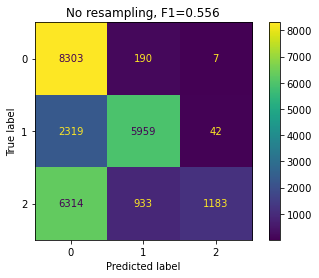

True quantities: 0:8500 1:{np.count_nonzero(ytest.values==1)} 2:{np.count_nonzero(ytest.values==2)}


C:\Users\johnh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


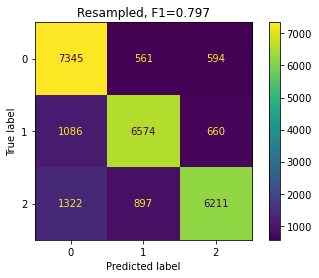

In [7]:
# print(f1(ytest, model_imb.predict(Xtest),average=None))
plot_confusion_matrix(model_imb,Xtest,ytest)
plt.title(f'No resampling, F1={f1_score(ytest,model_imb.predict(Xtest),average="weighted"):.3g}')
plt.show()
print(f'True quantities: 0:{np.count_nonzero(ytest.values==0)} ' + \
      '1:{np.count_nonzero(ytest.values==1)} ' + \
      '2:{np.count_nonzero(ytest.values==2)}')
# print(f1(ytest, pipeline.predict(Xtest),average=None))
plot_confusion_matrix(pipeline,Xtest,ytest)
plt.title(f'Resampled, F1={f1_score(ytest,pipeline.predict(Xtest),average="weighted"):.3g}')
plt.show()


### Conclusion

We can see the effects of resampling. As one would expect, the  model trained on the resampled data predicted the smaller classes more often than the model trained on the skewed data. Unfortunately, this led to more misclassification of the majority class. So, the implementation of oversampling must be used with prudence guided by field knowledge. 